<style>
@keyframes gradientMove {
  0% { background-position: 0% 50%; }
  50% { background-position: 100% 50%; }
  100% { background-position: 0% 50%; }
}
.gradient-bg {
  border-radius: 10px;
  background: linear-gradient(-45deg, #ee7752, #e73c7e, #23a6d5, #23d5ab);
  background-size: 300% 300%;
  animation: gradientMove 8s ease infinite;
  font-size: 130%;
  text-align: left;
}
</style>

<div class="gradient-bg">
  <br/>
  <center><h1><font color='white'>Emrecan Üncü - CRM SALES PROJECT</font></h1></center>
  <br/>
</div>


In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.impute import SimpleImputer

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. VERİ YÜKLEME
# =============================================================================

In [3]:
DATA_PATH = r"C:\Users\NITRO\Desktop\CRM_Data_Analysis_for_Sales\Data\orginal data"

In [5]:

accounts_df = pd.read_csv(f"{DATA_PATH}/accounts.csv")
products_df = pd.read_csv(f"{DATA_PATH}/products.csv")
sales_pipeline_df = pd.read_csv(f"{DATA_PATH}/sales_pipeline.csv")
sales_team_df = pd.read_csv(f"{DATA_PATH}/sales_teams.csv")


In [6]:
# Veri setlerinin kopyalarını oluştur (orijinali korumak için)
accounts_clean = accounts_df.copy()
sales_pipeline_clean = sales_pipeline_df.copy()
sales_teams_clean = sales_team_df.copy()
products_clean = products_df.copy()

# =============================================================================
# 2. EKSİK VERİ YÖNETİMİ (MISSING DATA HANDLING)
# =============================================================================

In [7]:
def handle_missing_data(df, table_name):
    print(f"\n--- {table_name} ---")
    missing_before = df.isnull().sum().sum()
    print(f"Toplam eksik değer (önce): {missing_before}")
    
    # Eksik veri stratejisi
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            missing_pct = (missing_count / len(df)) * 100
            print(f"  • {col}: {missing_count} eksik (%{missing_pct:.2f})")
            
            # Stratejiler:
            # 1. Kategorik değişkenler için mod (en sık değer)
            if df[col].dtype == 'object':
                mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
                df[col].fillna(mode_value, inplace=True)
                print(f"    → '{mode_value}' ile dolduruldu (mod)")
            
            # 2. Sayısal değişkenler için medyan
            elif df[col].dtype in ['int64', 'float64']:
                if missing_pct < 30:  # %30'dan az eksikse medyan kullan
                    median_value = df[col].median()
                    df[col].fillna(median_value, inplace=True)
                    print(f"    → {median_value} ile dolduruldu (medyan)")
                else:  # %30'dan fazlaysa sütunu düşünebiliriz
                    print(f"    → UYARI: Çok fazla eksik veri!")
    
    missing_after = df.isnull().sum().sum()
    print(f"Toplam eksik değer (sonra): {missing_after}")
    return df

In [8]:
accounts_clean = handle_missing_data(accounts_clean, "ACCOUNTS")
sales_pipeline_clean = handle_missing_data(sales_pipeline_clean, "SALES_PIPELINE")
sales_teams_clean = handle_missing_data(sales_teams_clean, "SALES_TEAMS")
products_clean = handle_missing_data(products_clean, "PRODUCTS")


--- ACCOUNTS ---
Toplam eksik değer (önce): 70
  • subsidiary_of: 70 eksik (%82.35)
    → 'Acme Corporation' ile dolduruldu (mod)
Toplam eksik değer (sonra): 0

--- SALES_PIPELINE ---
Toplam eksik değer (önce): 6103
  • account: 1425 eksik (%16.19)
    → 'Hottechi' ile dolduruldu (mod)
  • engage_date: 500 eksik (%5.68)
    → '2017-07-22' ile dolduruldu (mod)
  • close_date: 2089 eksik (%23.74)
    → '2017-05-22' ile dolduruldu (mod)
  • close_value: 2089 eksik (%23.74)
    → 472.0 ile dolduruldu (medyan)
Toplam eksik değer (sonra): 0

--- SALES_TEAMS ---
Toplam eksik değer (önce): 0
Toplam eksik değer (sonra): 0

--- PRODUCTS ---
Toplam eksik değer (önce): 0
Toplam eksik değer (sonra): 0


# =============================================================================
# 3. AYKIRI DEĞER YÖNETİMİ (OUTLIER HANDLING)
# =============================================================================

In [9]:
def handle_outliers(df, column, method='cap'):
    """
    method='cap': Aykırı değerleri sınırlara çek (winsorization)
    method='remove': Aykırı değerleri kaldır
    """
    if column not in df.columns or df[column].dtype not in ['int64', 'float64']:
        return df
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
    
    if outliers_count > 0:
        print(f"\n{column}:")
        print(f"  Aykırı değer sayısı: {outliers_count}")
        print(f"  Alt sınır: {lower_bound:.2f}, Üst sınır: {upper_bound:.2f}")
        
        if method == 'cap':
            df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
            print(f"  → Aykırı değerler sınırlara çekildi")
        elif method == 'remove':
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
            print(f"  → Aykırı değerler silindi")
    
    return df


In [10]:
if 'revenue' in accounts_clean.columns:
    accounts_clean = handle_outliers(accounts_clean, 'revenue', method='cap')

if 'employees' in accounts_clean.columns:
    accounts_clean = handle_outliers(accounts_clean, 'employees', method='cap')

# SALES_PIPELINE tablosu için
if 'close_value' in sales_pipeline_clean.columns:
    sales_pipeline_clean = handle_outliers(sales_pipeline_clean, 'close_value', method='cap')

# PRODUCTS tablosu için
if 'sales_price' in products_clean.columns:
    products_clean = handle_outliers(products_clean, 'sales_price_bigint', method='cap')


revenue:
  Aykırı değer sayısı: 6
  Alt sınır: -2869.28, Üst sınır: 6107.76
  → Aykırı değerler sınırlara çekildi

employees:
  Aykırı değer sayısı: 8
  Alt sınır: -5445.00, Üst sınır: 12219.00
  → Aykırı değerler sınırlara çekildi

close_value:
  Aykırı değer sayısı: 1863
  Alt sınır: -1627.88, Üst sınır: 2713.12
  → Aykırı değerler sınırlara çekildi


# =============================================================================
# 4. VERİ TİPİ DÖNÜŞÜMLERİ
# =============================================================================

In [11]:
# Tarih sütunlarını datetime'a çevir
date_columns_sales = ['engage_date', 'close_date']
for col in date_columns_sales:
    if col in sales_pipeline_clean.columns:
        try:
            sales_pipeline_clean[col] = pd.to_datetime(sales_pipeline_clean[col], errors='coerce')
            print(f"✓ {col} datetime'a çevrildi")
        except:
            print(f"✗ {col} çevrilemedi")


✓ engage_date datetime'a çevrildi
✓ close_date datetime'a çevrildi


In [12]:
# Text sütunlarını temizle (boşlukları kaldır)
print("\nText sütunları temizleniyor...")
for df_name, df in [('accounts', accounts_clean), ('sales_pipeline', sales_pipeline_clean), 
                     ('sales_teams', sales_teams_clean), ('products', products_clean)]:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.strip()
            print(f"✓ {df_name}.{col} temizlendi")


Text sütunları temizleniyor...
✓ accounts.account temizlendi
✓ accounts.sector temizlendi
✓ accounts.office_location temizlendi
✓ accounts.subsidiary_of temizlendi
✓ sales_pipeline.opportunity_id temizlendi
✓ sales_pipeline.sales_agent temizlendi
✓ sales_pipeline.product temizlendi
✓ sales_pipeline.account temizlendi
✓ sales_pipeline.deal_stage temizlendi
✓ sales_teams.sales_agent temizlendi
✓ sales_teams.manager temizlendi
✓ sales_teams.regional_office temizlendi
✓ products.product temizlendi
✓ products.series temizlendi


# =============================================================================
# 5. FEATURE ENGINEERING (ÖZELLİK MÜHENDİSLİĞİ)
# =============================================================================

# 5.1. ACCOUNTS tablosu için yeni özellikler

In [15]:
# Şirket yaşı hesapla
if 'year_established' in accounts_clean.columns:
    current_year = datetime.now().year
    accounts_clean['company_age'] = current_year - accounts_clean['year_established']
    print("✓ company_age oluşturuldu")

✓ company_age oluşturuldu


In [16]:
# Çalışan başına gelir
if 'revenue' in accounts_clean.columns and 'employees' in accounts_clean.columns:
    accounts_clean['revenue_per_employee'] = accounts_clean['revenue'] / accounts_clean['employees'].replace(0, np.nan)
    print("✓ revenue_per_employee oluşturuldu")

✓ revenue_per_employee oluşturuldu


In [19]:
# Şirket büyüklük kategorisi
if 'employees' in accounts_clean.columns:
    accounts_clean['company_size'] = pd.cut(accounts_clean['employees'], 
                                             bins=[0, 50, 250, 1000, np.inf],
                                             labels=['Small', 'Medium', 'Large', 'Enterprise'])
    print("✓ company_size kategorisi oluşturuldu")

✓ company_size kategorisi oluşturuldu


# 5.2. SALES_PIPELINE tablosu için yeni özellikler

In [ ]:
# Satış döngüsü süresi (gün)
if 'engage_date_text' in sales_pipeline_clean.columns and 'close_date_text' in sales_pipeline_clean.columns:
    sales_pipeline_clean['sales_cycle_days'] = (sales_pipeline_clean['close_date_text'] - 
                                                 sales_pipeline_clean['engage_date_text']).dt.days
    print("✓ sales_cycle_days oluşturuldu")

In [21]:
# Ay ve çeyrek bilgileri
if 'close_date' in sales_pipeline_clean.columns:
    sales_pipeline_clean['close_month'] = sales_pipeline_clean['close_date'].dt.month
    sales_pipeline_clean['close_quarter'] = sales_pipeline_clean['close_date'].dt.quarter
    sales_pipeline_clean['close_year'] = sales_pipeline_clean['close_date'].dt.year
    print("✓ Zaman özellikleri oluşturuldu (month, quarter, year)")

✓ Zaman özellikleri oluşturuldu (month, quarter, year)


In [22]:
# Deal stage'i binary'e çevir (Won/Lost vs Others)
if 'deal_stage' in sales_pipeline_clean.columns:
    sales_pipeline_clean['is_won'] = (sales_pipeline_clean['deal_stage'] == 'Won').astype(int)
    sales_pipeline_clean['is_lost'] = (sales_pipeline_clean['deal_stage'] == 'Lost').astype(int)
    print("✓ is_won ve is_lost binary özellikleri oluşturuldu")

✓ is_won ve is_lost binary özellikleri oluşturuldu


# =============================================================================
# 6. KATEGORİK DEĞİŞKEN KODLAMA (ENCODING)
# =============================================================================

In [23]:
# Label Encoding için sütunlar
label_encode_columns = {
    'accounts': ['sector', 'office_location'],
    'sales_pipeline': ['deal_stage', 'product'],
    'sales_teams': ['manager', 'regional_office'],
    'products': ['series']
}

In [24]:
# Label Encoding uygula
le = LabelEncoder()

In [ ]:
for table, columns in label_encode_columns.items():
    if table == 'accounts':
        df = accounts_clean
    elif table == 'sales_pipeline':
        df = sales_pipeline_clean
    elif table == 'sales_teams':
        df = sales_teams_clean
    else:
        df = products_clean
    
    for col in columns:
        if col in df.columns:
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            print(f"✓ {table}.{col} → {col}_encoded")

In [ ]:
# Company size için one-hot encoding
if 'company_size' in accounts_clean.columns:
    size_dummies = pd.get_dummies(accounts_clean['company_size'], prefix='size')
    accounts_clean = pd.concat([accounts_clean, size_dummies], axis=1)
    print(f"✓ company_size için {len(size_dummies.columns)} dummy değişken oluşturuldu")


# =============================================================================
# 7. VERİ SETLERİNİ BİRLEŞTİRME (MERGING)
# =============================================================================

In [25]:

# Sales Pipeline'ı merkez al
master_df = sales_pipeline_clean.copy()
print(f"Başlangıç boyutu: {master_df.shape}")

Başlangıç boyutu: (8800, 13)


In [27]:
# PRODUCTS tablosu ile birleştir
if 'product' in master_df.columns and 'product' in products_clean.columns:
    master_df = master_df.merge(products_clean, on='product', how='left', suffixes=('', '_product'))
    print(f"✓ PRODUCTS birleştirildi: {master_df.shape}")

✓ PRODUCTS birleştirildi: (8800, 15)


In [28]:
# SALES_TEAMS tablosu ile birleştir
if 'sales_agent' in master_df.columns and 'sales_agent' in sales_teams_clean.columns:
    master_df = master_df.merge(sales_teams_clean, on='sales_agent', how='left', suffixes=('', '_team'))
    print(f"✓ SALES_TEAMS birleştirildi: {master_df.shape}")

✓ SALES_TEAMS birleştirildi: (8800, 17)


In [29]:
# ACCOUNTS tablosu ile birleştir
if 'account' in master_df.columns and 'account' in accounts_clean.columns:
    master_df = master_df.merge(accounts_clean, on='account', how='left', suffixes=('', '_account'))
    print(f"✓ ACCOUNTS birleştirildi: {master_df.shape}")

✓ ACCOUNTS birleştirildi: (8800, 26)


# =============================================================================
# 8. ÖZELLİK SEÇİMİ (FEATURE SELECTION)
# =============================================================================

In [30]:
# Gereksiz sütunları kaldır
columns_to_drop = []

In [31]:
# ID ve text sütunlarını kaldır (encoded versiyonları varsa)
for col in master_df.columns:
    if col.endswith('_text') and f'{col}_encoded' in master_df.columns:
        columns_to_drop.append(col)

In [33]:
# Tarih sütunlarını kaldır (türetilmiş özellikler varsa)
if 'close_month' in master_df.columns:
    date_cols = [col for col in master_df.columns if 'date' in col.lower() and master_df[col].dtype == 'datetime64[ns]']
    columns_to_drop.extend(date_cols)

In [32]:
# Yüksek korelasyonlu sütunları bul ve kaldır
numeric_cols = master_df.select_dtypes(include=[np.number]).columns
correlation_matrix = master_df[numeric_cols].corr().abs()

In [34]:
# Üst üçgen matris
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

In [35]:
# 0.95'ten yüksek korelasyonlu sütunları bul
high_corr_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

In [36]:
print(f"\nYüksek korelasyonlu sütunlar ({len(high_corr_cols)}): {high_corr_cols}")
columns_to_drop.extend(high_corr_cols)


Yüksek korelasyonlu sütunlar (3): ['close_quarter', 'employees', 'company_age']


In [37]:
# Sütunları kaldır
columns_to_drop = list(set(columns_to_drop))  # Tekrarları kaldır
master_df_clean = master_df.drop(columns=[col for col in columns_to_drop if col in master_df.columns])

In [38]:
print(f"\n{len(columns_to_drop)} sütun kaldırıldı")
print(f"Kalan sütun sayısı: {master_df_clean.shape[1]}")


5 sütun kaldırıldı
Kalan sütun sayısı: 21


# =============================================================================
# 9. NORMALİZASYON ve STANDARDİZASYON
# =============================================================================

In [39]:
# Sadece numerik sütunları al
numeric_features = master_df_clean.select_dtypes(include=[np.number]).columns.tolist()


In [45]:
# Hedef değişkeni çıkar (varsa)
target_cols = ['is_won', 'is_lost', 'close_value']
features_to_scale = [col for col in numeric_features if col not in target_cols]

In [46]:
print(f"\n{len(features_to_scale)} sütun normalize edilecek")


6 sütun normalize edilecek


In [47]:
# StandardScaler (z-score normalization)
scaler_standard = StandardScaler()
master_df_scaled = master_df_clean.copy()

In [48]:
if features_to_scale:
    master_df_scaled[features_to_scale] = scaler_standard.fit_transform(master_df_clean[features_to_scale])
    print("✓ StandardScaler uygulandı (z-score)")

✓ StandardScaler uygulandı (z-score)


In [49]:
# MinMaxScaler (0-1 arası normalization) - alternatif
scaler_minmax = MinMaxScaler()
master_df_minmax = master_df_clean.copy()

In [54]:
if features_to_scale:
    master_df_minmax[features_to_scale] = scaler_minmax.fit_transform(master_df_clean[features_to_minmax[features_to_scale]])
    print("✓ MinMaxScaler uygulandı (0-1)")


    ###bu kod parçasında hata var

NameError: name 'features_to_minmax' is not defined

# =============================================================================
# 10. VERİ KALİTESİ KONTROLÜ
# =============================================================================

In [55]:
def final_quality_check(df, df_name):
    print(f"\n--- {df_name} ---")
    print(f"Boyut: {df.shape}")
    print(f"Eksik değer: {df.isnull().sum().sum()}")
    print(f"Tekrarlayan satır: {df.duplicated().sum()}")
    print(f"Numerik sütun: {len(df.select_dtypes(include=[np.number]).columns)}")
    print(f"Kategorik sütun: {len(df.select_dtypes(include=['object']).columns)}")
    print(f"Bellek kullanımı: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

In [56]:
final_quality_check(accounts_clean, "ACCOUNTS (temiz)")
final_quality_check(sales_pipeline_clean, "SALES_PIPELINE (temiz)")
final_quality_check(sales_teams_clean, "SALES_TEAMS (temiz)")
final_quality_check(products_clean, "PRODUCTS (temiz)")
final_quality_check(master_df_clean, "MASTER_DF (birleştirilmiş)")


--- ACCOUNTS (temiz) ---
Boyut: (85, 10)
Eksik değer: 0
Tekrarlayan satır: 0
Numerik sütun: 5
Kategorik sütun: 4
Bellek kullanımı: 0.02 MB

--- SALES_PIPELINE (temiz) ---
Boyut: (8800, 13)
Eksik değer: 0
Tekrarlayan satır: 0
Numerik sütun: 6
Kategorik sütun: 5
Bellek kullanımı: 2.81 MB

--- SALES_TEAMS (temiz) ---
Boyut: (35, 3)
Eksik değer: 0
Tekrarlayan satır: 0
Numerik sütun: 0
Kategorik sütun: 3
Bellek kullanımı: 0.01 MB

--- PRODUCTS (temiz) ---
Boyut: (7, 3)
Eksik değer: 0
Tekrarlayan satır: 0
Numerik sütun: 1
Kategorik sütun: 2
Bellek kullanımı: 0.00 MB

--- MASTER_DF (birleştirilmiş) ---
Boyut: (8800, 21)
Eksik değer: 2960
Tekrarlayan satır: 0
Numerik sütun: 9
Kategorik sütun: 11
Bellek kullanımı: 5.82 MB


# =============================================================================
# 11. TEMİZ VERİLERİ KAYDETME
# =============================================================================

In [57]:
# CSV olarak kaydet
accounts_clean.to_csv('accounts_clean.csv', index=False)
sales_pipeline_clean.to_csv('sales_pipeline_clean.csv', index=False)
sales_teams_clean.to_csv('sales_teams_clean.csv', index=False)
products_clean.to_csv('products_clean.csv', index=False)
master_df_clean.to_csv('master_df_clean.csv', index=False)
master_df_scaled.to_csv('master_df_scaled.csv', index=False)

# =============================================================================
# 12. GÖRSELLEŞTIRMELER - ÖNCE vs SONRA
# =============================================================================


13. GÖRSELLEŞTIRMELER OLUŞTURULUYOR...

✓ Görselleştirmeler 'data_preparation_results.png' olarak kaydedildi


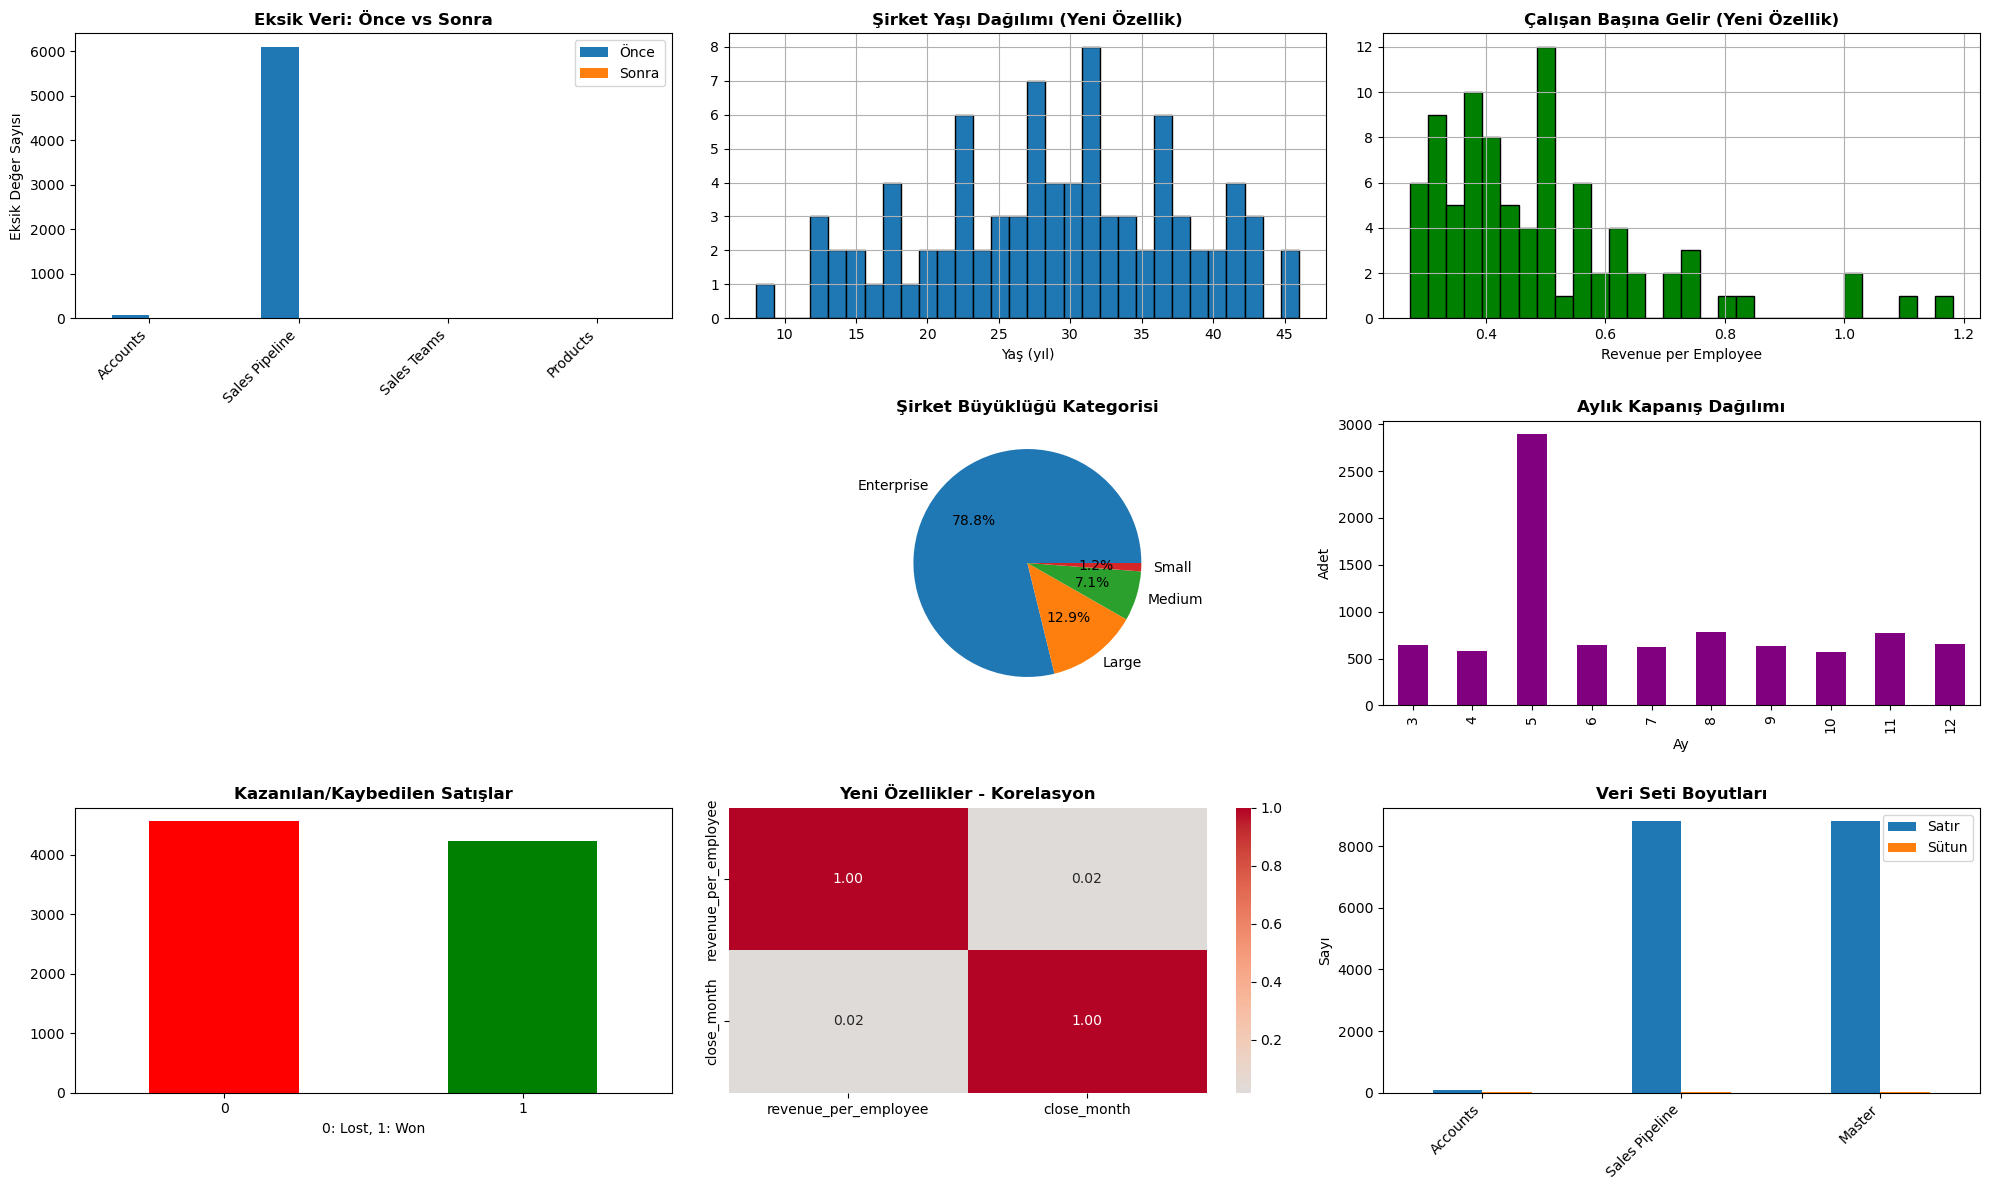

In [59]:


print("\n" + "="*80)
print("13. GÖRSELLEŞTIRMELER OLUŞTURULUYOR...")
print("="*80)

fig = plt.figure(figsize=(20, 12))

# 1. Eksik veri karşılaştırması
plt.subplot(3, 3, 1)
missing_comparison = pd.DataFrame({
    'Önce': [accounts_df.isnull().sum().sum(), sales_pipeline_df.isnull().sum().sum(),
             sales_team_df.isnull().sum().sum(), products_df.isnull().sum().sum()],
    'Sonra': [accounts_clean.isnull().sum().sum(), sales_pipeline_clean.isnull().sum().sum(),
              sales_teams_clean.isnull().sum().sum(), products_clean.isnull().sum().sum()]
}, index=['Accounts', 'Sales Pipeline', 'Sales Teams', 'Products'])
missing_comparison.plot(kind='bar', ax=plt.gca())
plt.title('Eksik Veri: Önce vs Sonra', fontweight='bold')
plt.ylabel('Eksik Değer Sayısı')
plt.xticks(rotation=45, ha='right')

# 2. Company age dağılımı
if 'company_age' in accounts_clean.columns:
    plt.subplot(3, 3, 2)
    accounts_clean['company_age'].hist(bins=30, edgecolor='black')
    plt.title('Şirket Yaşı Dağılımı (Yeni Özellik)', fontweight='bold')
    plt.xlabel('Yaş (yıl)')

# 3. Revenue per employee dağılımı
if 'revenue_per_employee' in accounts_clean.columns:
    plt.subplot(3, 3, 3)
    accounts_clean['revenue_per_employee'].hist(bins=30, edgecolor='black', color='green')
    plt.title('Çalışan Başına Gelir (Yeni Özellik)', fontweight='bold')
    plt.xlabel('Revenue per Employee')

# 4. Sales cycle days
if 'sales_cycle_days' in sales_pipeline_clean.columns:
    plt.subplot(3, 3, 4)
    sales_pipeline_clean['sales_cycle_days'].hist(bins=30, edgecolor='black', color='orange')
    plt.title('Satış Döngüsü Süresi (Yeni Özellik)', fontweight='bold')
    plt.xlabel('Gün')

# 5. Company size dağılımı
if 'company_size' in accounts_clean.columns:
    plt.subplot(3, 3, 5)
    accounts_clean['company_size'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Şirket Büyüklüğü Kategorisi', fontweight='bold')
    plt.ylabel('')

# 6. Close month dağılımı
if 'close_month' in sales_pipeline_clean.columns:
    plt.subplot(3, 3, 6)
    sales_pipeline_clean['close_month'].value_counts().sort_index().plot(kind='bar', color='purple')
    plt.title('Aylık Kapanış Dağılımı', fontweight='bold')
    plt.xlabel('Ay')
    plt.ylabel('Adet')

# 7. Is_won dağılımı
if 'is_won' in sales_pipeline_clean.columns:
    plt.subplot(3, 3, 7)
    sales_pipeline_clean['is_won'].value_counts().plot(kind='bar', color=['red', 'green'])
    plt.title('Kazanılan/Kaybedilen Satışlar', fontweight='bold')
    plt.xlabel('0: Lost, 1: Won')
    plt.xticks(rotation=0)

# 8. Korelasyon matrisi (yeni özellikler)
plt.subplot(3, 3, 8)
new_features = ['company_age', 'revenue_per_employee', 'sales_cycle_days', 'close_month']
existing_features = [col for col in new_features if col in master_df_clean.columns]
if len(existing_features) > 1:
    corr_new = master_df_clean[existing_features].corr()
    sns.heatmap(corr_new, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Yeni Özellikler - Korelasyon', fontweight='bold')

# 9. Veri seti boyut karşılaştırması
plt.subplot(3, 3, 9)
sizes = pd.DataFrame({
    'Satır': [accounts_df.shape[0], sales_pipeline_df.shape[0], master_df_clean.shape[0]],
    'Sütun': [accounts_df.shape[1], sales_pipeline_df.shape[1], master_df_clean.shape[1]]
}, index=['Accounts', 'Sales Pipeline', 'Master'])
sizes.plot(kind='bar', ax=plt.gca())
plt.title('Veri Seti Boyutları', fontweight='bold')
plt.ylabel('Sayı')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('data_preparation_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Görselleştirmeler 'data_preparation_results.png' olarak kaydedildi")
